### ANALYSE DES DONNÉES D'INCIDENTS ET D'ARRESTATION DANS LA VILLE DE CHICAGO

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, sys, logging
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#### Load the data of crime analysis

In [3]:
df_crime = pd.read_csv('../DATA/dataset-inc-both-sexes-in-2022-prostate.csv')
df_crime.head()

,Alpha-3 code,Cancer code,Population code (ISO/UN),Country,Label,Sex,Number,95% UI low,95% UI high,Number.1,ASR (World),Crude rate,Cumulative risk
0,DZA,27.0,12.0,12.0,Algeria,0.0,3514,3294.0,3749.0,3514,15.5,15.3,1.9
1,AGO,27.0,24.0,24.0,Angola,0.0,2618,2495.0,2747.0,2618,47.9,15.1,5.7
2,BWA,27.0,72.0,72.0,Botswana,0.0,159,118.0,214.0,159,23.9,13.4,2.8
3,BDI,27.0,108.0,108.0,Burundi,0.0,822,608.0,1111.0,822,38.0,13.1,4.5
4,CMR,27.0,120.0,120.0,Cameroon,0.0,2050,1318.0,3189.0,2050,38.6,14.7,4.7


In [4]:
# la dimension des données
df_crime.shape

(55, 13)

In [6]:
df_crime.describe(exclude=["object", 'bool'])

,Cancer code,Population code (ISO/UN),Country,Sex,Number,95% UI low,95% UI high,Number.1,ASR (World),Crude rate,Cumulative risk
count,54.0,54.000000,54.000000,54.0,55.000000,54.000000,54.000000,55.000000,55.000000,55.000000,55.000000
mean,27.0,457.629630,457.629630,0.0,3744.618182,1680.722222,2287.259259,3744.618182,33.572727,16.605455,3.934000
std,0.0,251.290203,251.290203,0.0,13985.836705,2943.320993,3489.526806,13985.836705,16.623594,14.555302,1.994155
min,27.0,12.000000,12.000000,0.0,22.000000,12.000000,40.000000,22.000000,5.500000,2.000000,0.670000
25%,27.0,231.250000,231.250000,0.0,262.500000,129.250000,377.000000,262.500000,22.800000,10.300000,2.850000
50%,27.0,460.000000,460.000000,0.0,822.000000,609.000000,1151.000000,822.000000,31.900000,14.600000,3.700000
75%,27.0,692.000000,692.000000,0.0,2356.000000,2073.750000,2678.250000,2356.000000,41.100000,16.900000,4.750000
max,27.0,894.000000,894.000000,0.0,102977.000000,17459.000000,18597.000000,102977.000000,82.200000,104.500000,10.600000


In [10]:
df_crime.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                  int64
Ward                      int64
Community Area            int64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

In [12]:
## les valeurs manquantes
(df_crime.isnull().sum() / len(df_crime) )*100

ID                      0.000000
Case Number             0.000000
Date                    0.000000
Block                   0.000000
IUCR                    0.000000
Primary Type            0.000000
Description             0.000000
Location Description    0.421188
Arrest                  0.000000
Domestic                0.000000
Beat                    0.000000
District                0.000000
Ward                    0.000000
Community Area          0.000000
FBI Code                0.000000
X Coordinate            0.477217
Y Coordinate            0.477217
Year                    0.000000
Updated On              0.000000
Latitude                0.477217
Longitude               0.477217
Location                0.477217
dtype: float64

#### Visualisation or Exploratory Analysis Data(EDA)

In [17]:
### object data types
object_cols = df_crime.select_dtypes(include=['object']).columns

# numeric data types
num_cols = df_crime.select_dtypes(include=['number']).columns
num_cols, object_cols

(Index(['ID', 'Beat', 'District', 'Ward', 'Community Area', 'X Coordinate',
        'Y Coordinate', 'Year', 'Latitude', 'Longitude'],
       dtype='object'),
 Index(['Case Number', 'Block', 'IUCR', 'Primary Type', 'Description',
        'Location Description', 'FBI Code', 'Updated On', 'Location'],
       dtype='object'))

In [15]:
for col in object_cols:
    print(f"Column: {col}")
    print(df_crime[col].value_counts().head())
    print("\n")

Column: Case Number
Case Number
JH165644    3
JH332664    3
JH327052    3
JH528033    3
JH208794    2
Name: count, dtype: int64


Column: Date
Date
01/01/2024 12:00:00 AM    147
11/01/2024 12:00:00 AM     79
04/01/2024 12:00:00 AM     78
08/01/2024 12:00:00 AM     77
05/01/2024 12:00:00 AM     76
Name: count, dtype: int64


Column: Block
Block
001XX N STATE ST       691
0000X N STATE ST       488
0000X W TERMINAL ST    467
011XX S CANAL ST       354
076XX S CICERO AVE     331
Name: count, dtype: int64


Column: IUCR
IUCR
0486    20407
0820    19269
0810    18039
0460    16091
0910    15943
Name: count, dtype: int64


Column: Primary Type
Primary Type
THEFT                  60518
BATTERY                46129
CRIMINAL DAMAGE        28555
ASSAULT                23473
MOTOR VEHICLE THEFT    21713
Name: count, dtype: int64


Column: Description
Description
SIMPLE                     31537
DOMESTIC BATTERY SIMPLE    20407
$500 AND UNDER             19269
OVER $500                  18039
AUTO

In [16]:
# transformer la date en format datetime ou timestamp

df_crime['Date'] = pd.to_datetime(df_crime['Date'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p')
df_crime['Date'].head()

0   2024-12-31 23:58:00
1   2024-12-31 23:56:00
2   2024-12-31 23:55:00
3   2024-12-31 23:53:00
4   2024-12-31 23:50:00
Name: Date, dtype: datetime64[ns]

In [31]:
df_crime['Updated On'] = pd.to_datetime(df_crime['Updated On'], errors='coerce', format='%m/%d/%Y %I:%M:%S %p')
df_crime['Updated On'].head()

0   2025-11-02 15:41:09
1   2025-05-17 15:40:52
2   2025-11-02 15:41:09
3   2025-11-02 15:41:09
4   2025-05-17 15:40:52
Name: Updated On, dtype: datetime64[ns]

Column: Case Number


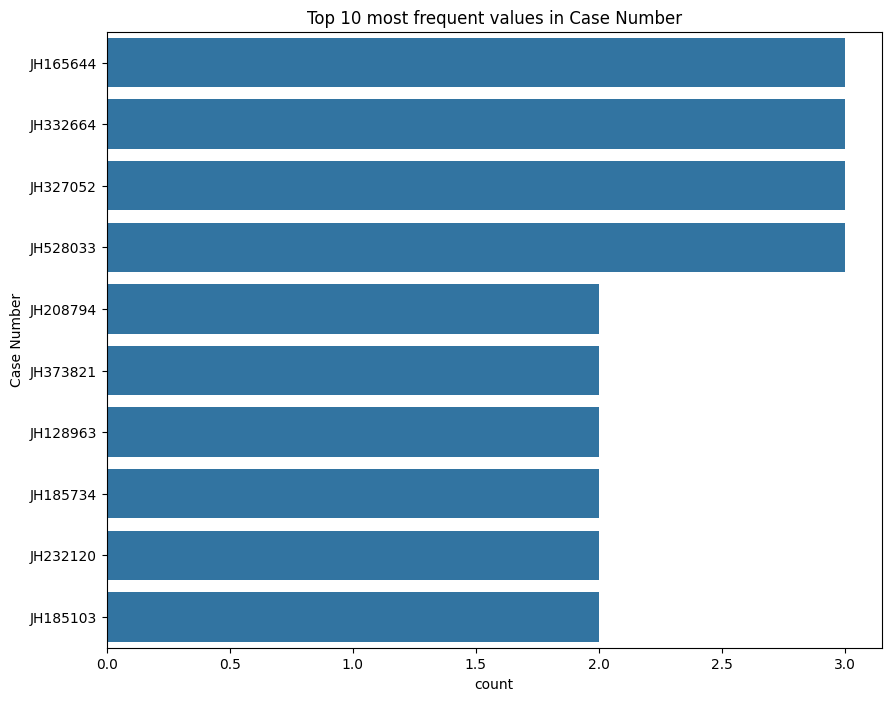



Column: Block


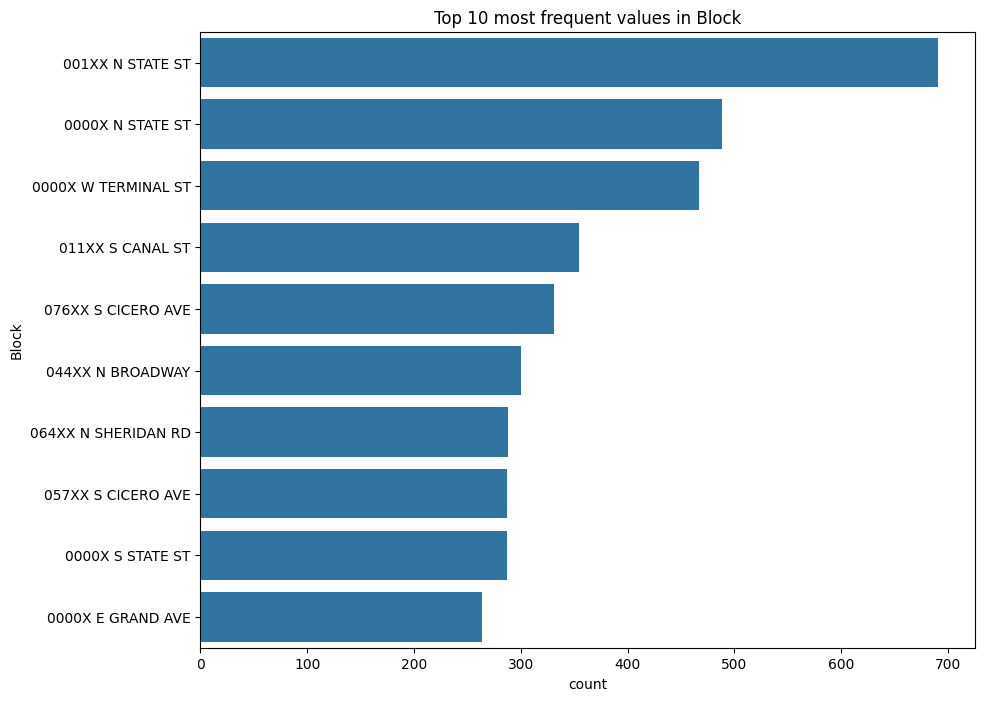



Column: IUCR


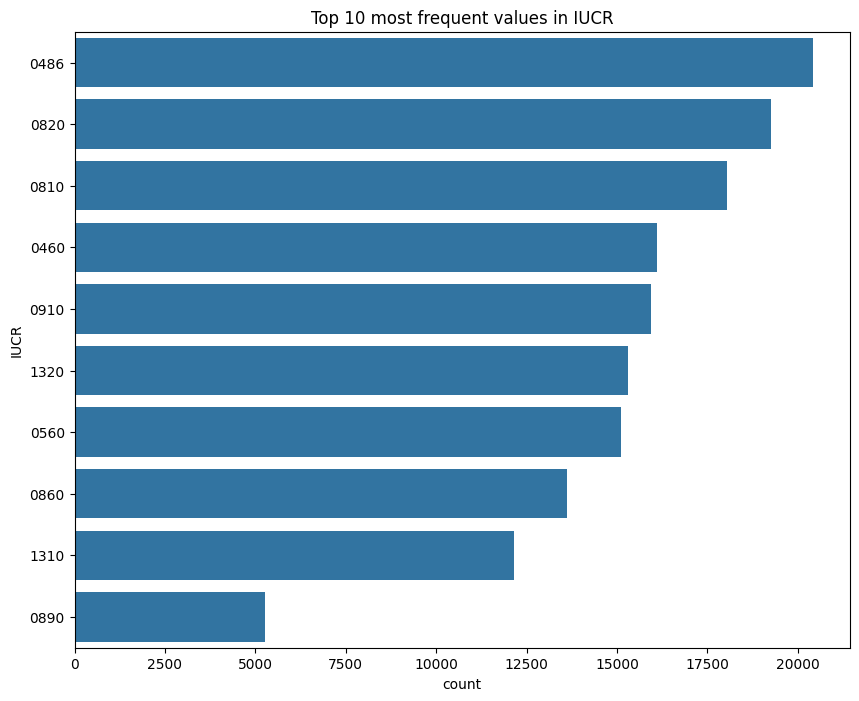



Column: Primary Type


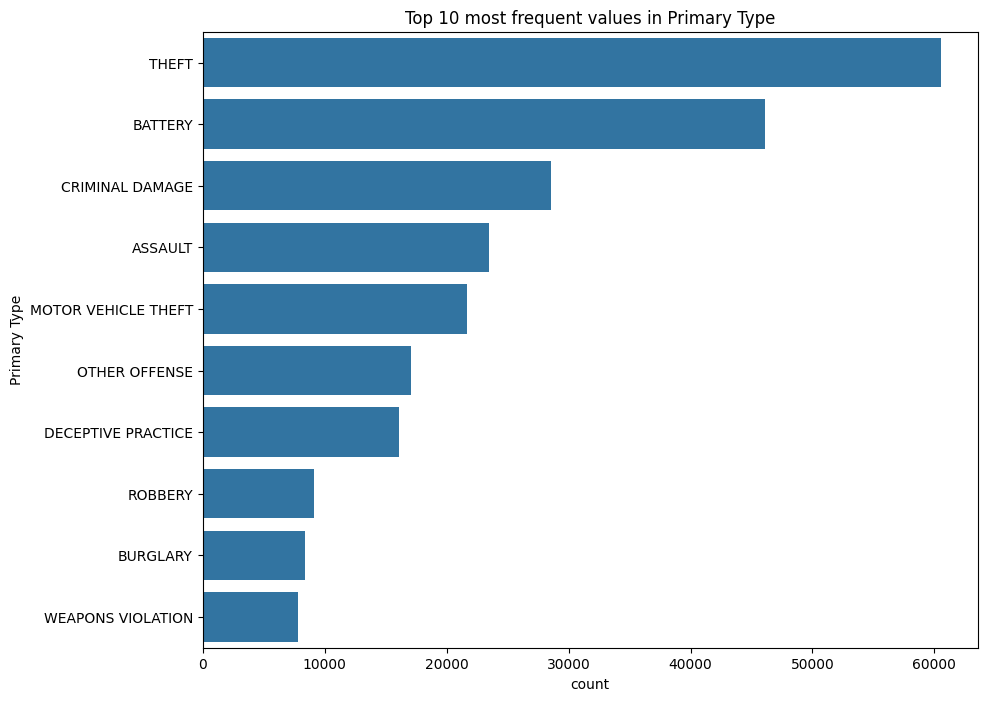



Column: Description


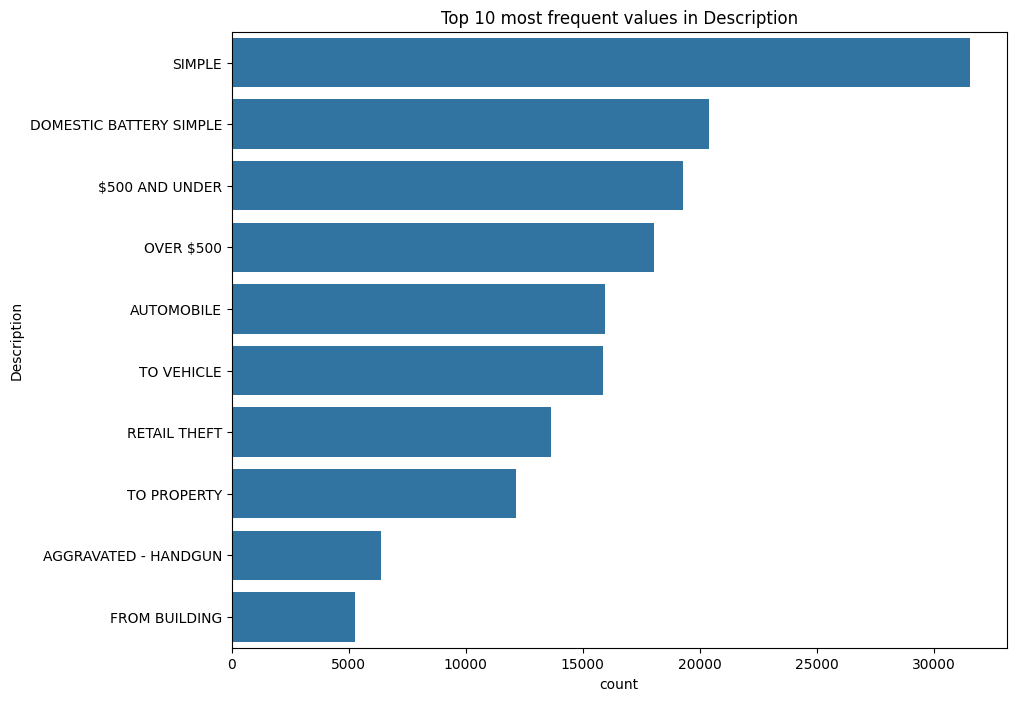



Column: Location Description


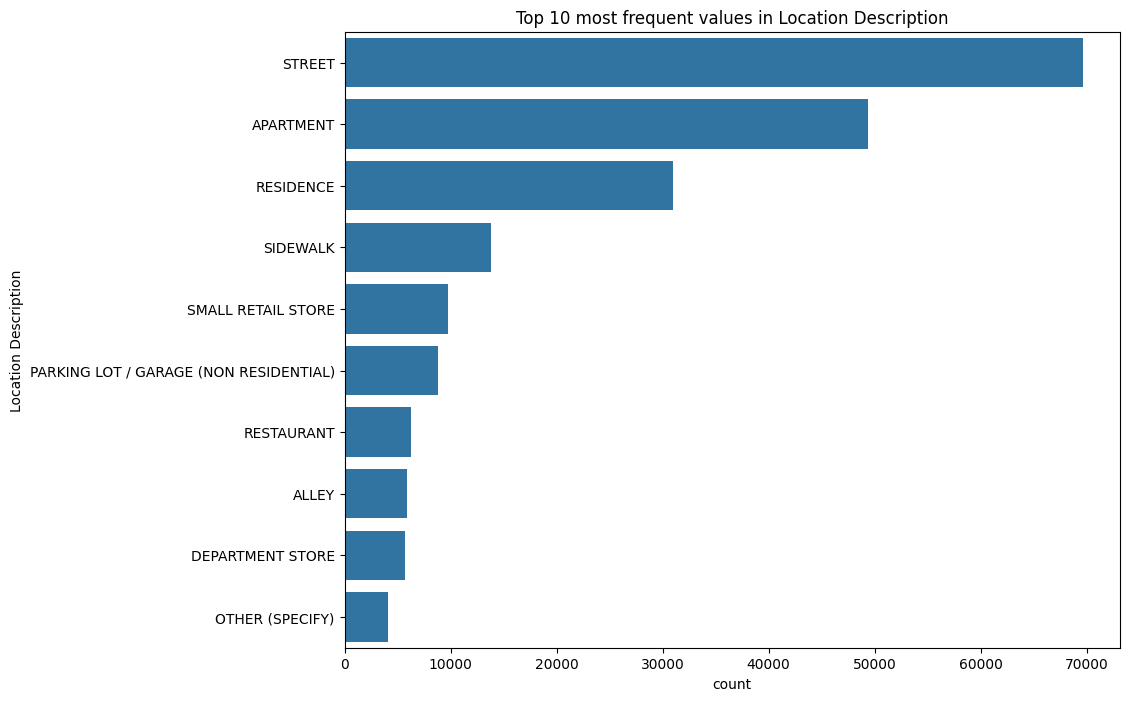



Column: FBI Code


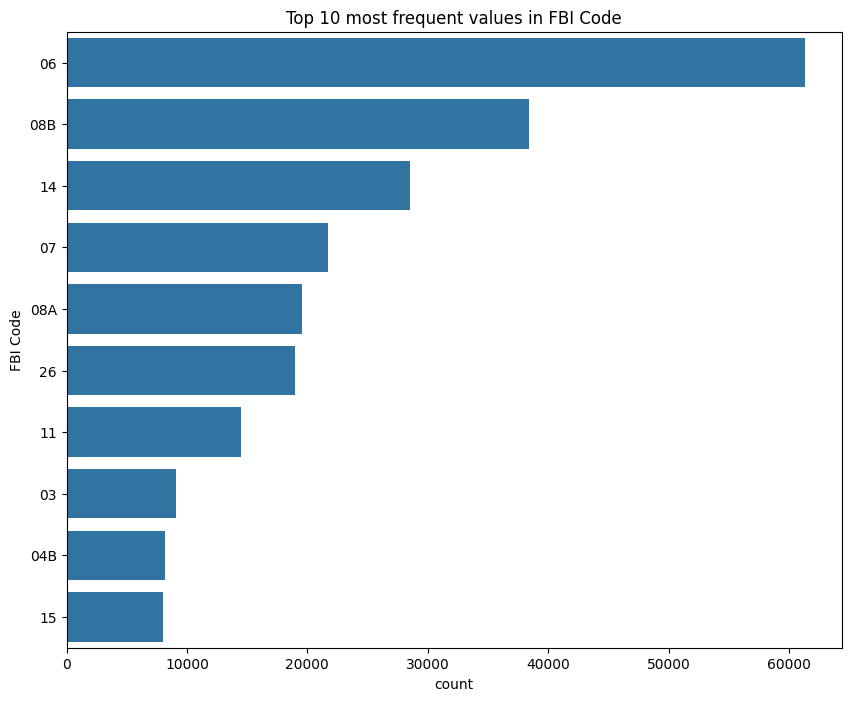



Column: Updated On


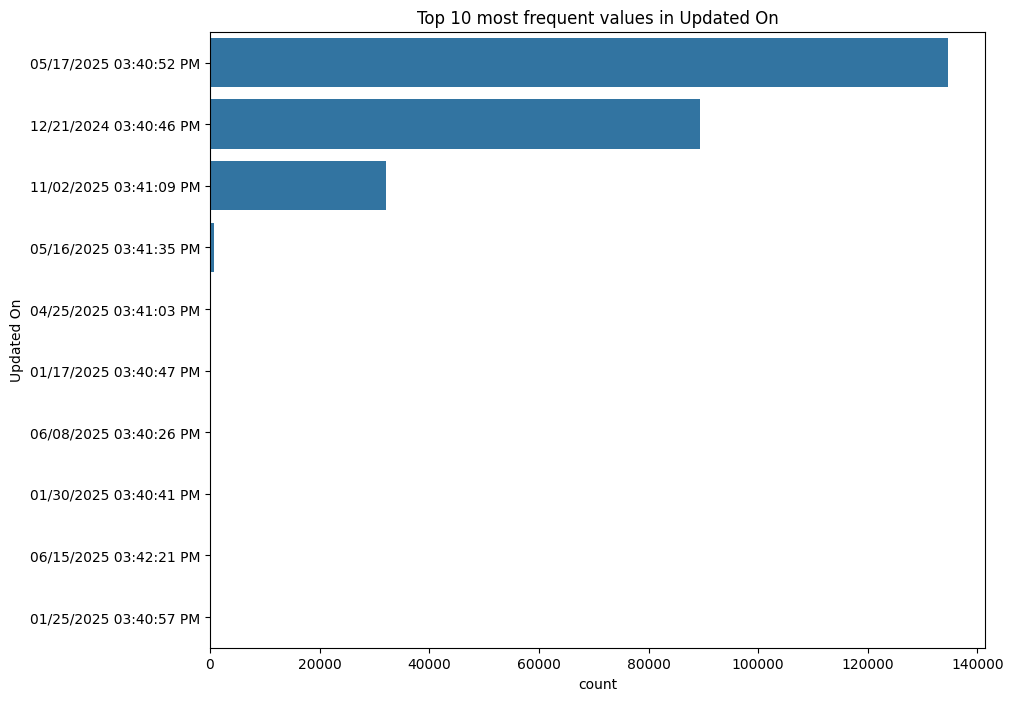



Column: Location


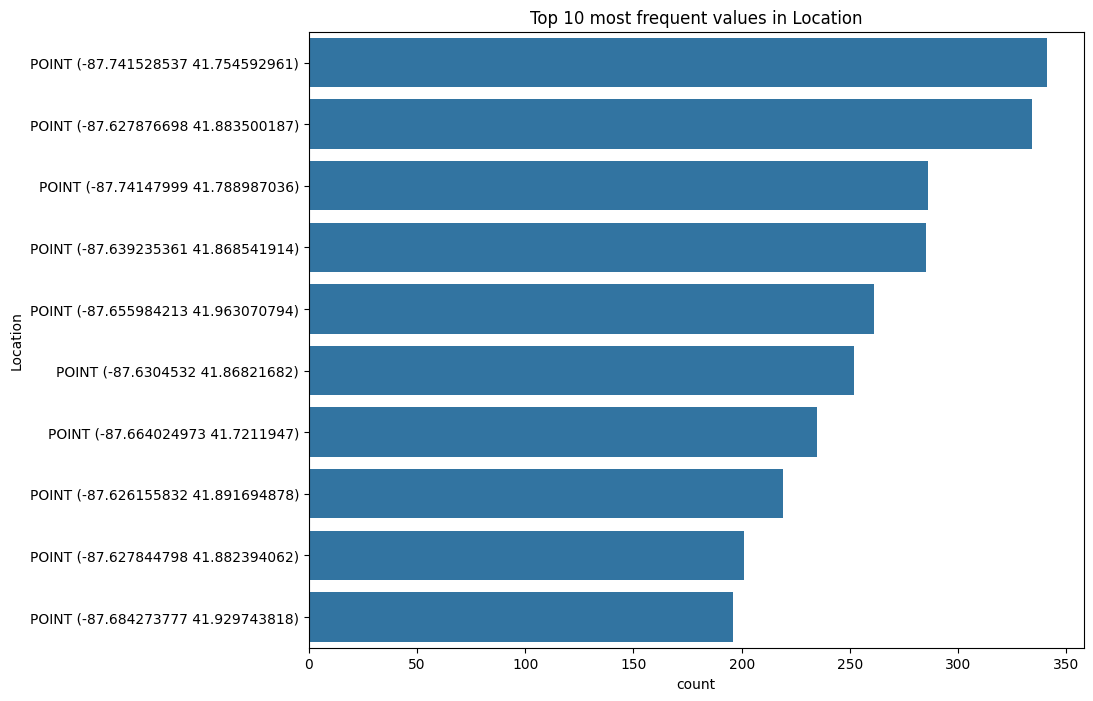

In [18]:
for col in object_cols:
    print(f"Column: {col}")
    plt.figure(figsize=(10,8))
    sns.countplot(y=df_crime[col], order=df_crime[col].value_counts().iloc[:10].index)
    plt.title(f'Top 10 most frequent values in {col}')
    plt.show()
    print("\n")

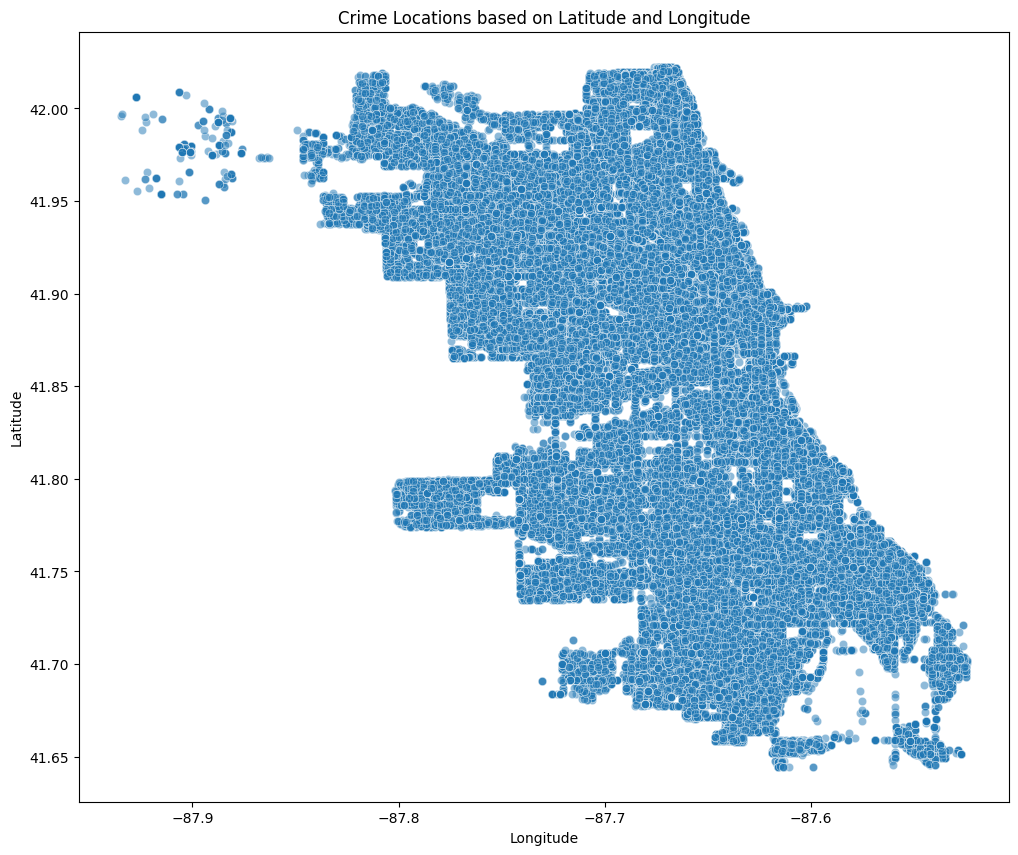

In [20]:
## un nuages de points entre latitude et longitude
plt.figure(figsize=(12,10))
sns.scatterplot(x='Longitude', y='Latitude', data=df_crime, alpha=0.5)
plt.title('Crime Locations based on Latitude and Longitude')
plt.show()

In [21]:
df_crime.Year.value_counts()

Year
2024    258792
Name: count, dtype: int64

In [ ]:
# utiliser plotly pour la visualisation interactive
#! pip install nbformat>=4.2.0
yearly_crime_counts = df_crime['Year'].value_counts().sort_index()
fig = go.Figure()
fig.add_trace(go.Bar(x=yearly_crime_counts.index, y=yearly_crime_counts.values, name='Yearly Crime Counts'))
fig.update_layout(title='Yearly Crime Counts', xaxis_title='Year', yaxis_title='Number of Crimes')
fig.show()

In [28]:
### relaation entre Xcordinate eet Y cordinate

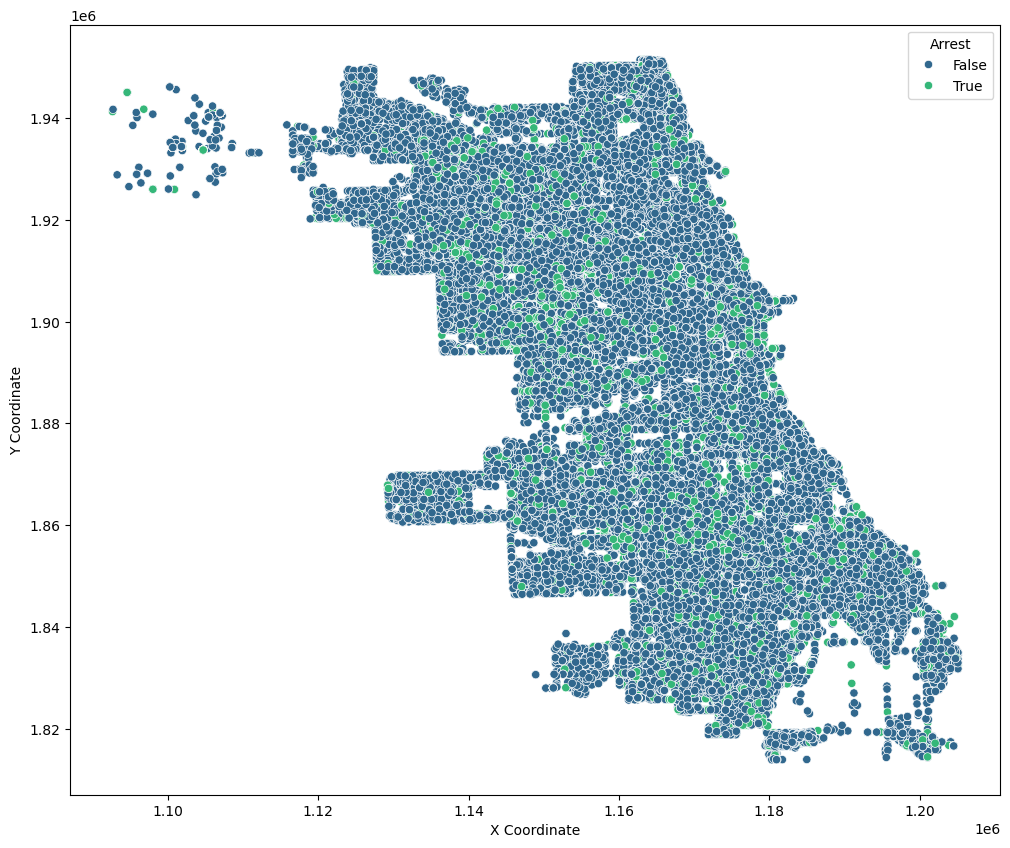

In [30]:
## relation entre X cordinate et Ycordinate

plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_crime, x='X Coordinate',y="Y Coordinate", hue="Arrest", palette='viridis')
plt.show()

<Axes: xlabel='Date', ylabel='Ward'>

/home/donerick/Data-science/env/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/donerick/Data-science/env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



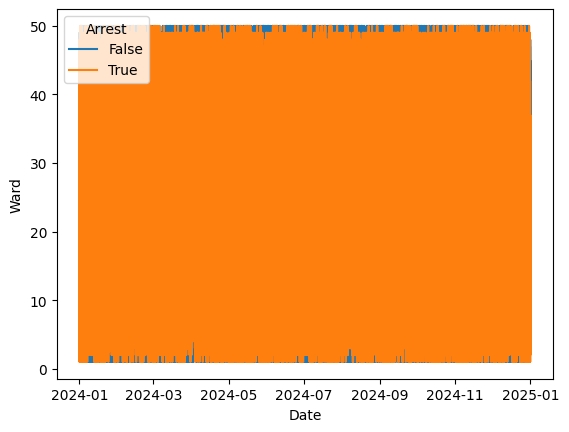

In [32]:
sns.lineplot(data=df_crime, x = 'Date', y='Ward',hue="Arrest")